In [1]:
# import attack_kernelbased
import attack_fgsm_dnn
import attack_df_dnn
# import attack_jsma
import attack_gen_dnn
import dataloader
import spatial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm

In [2]:
device = 'cpu'

In [3]:
X_train, X_test, y_train, y_test = dataloader.load(None, sklearn_dataset_name='EMNIST_Balanced')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

/Users/sang-geon/Documents/UCI_BIASLab/kernel_adversarial/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(torch.Size([98700, 784]),
 torch.Size([32900, 784]),
 torch.Size([98700]),
 torch.Size([32900]))

In [4]:
X_test = X_test[:100*classes]
y_test = y_test[:100*classes]

## CNN

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
)
Epoch 1
-------------------------------
loss: 3.849967  [    0/98700]
loss: 3.579520  [ 6400/98700]
loss: 1.635839  [12800/98700]
loss: 1.375265  [19200/98700]
loss: 1.338352  [25600/98700]
loss: 1.427647  [32000/98700]
loss: 1.341331  [38400/98700]
loss: 1.276738  [44800/98700]
loss: 1.646848  [51200/98700]
loss: 1.236518  [57600/98700]
loss: 1.337271  [64000/98700]
loss: 0.977698  [70400/98700]
loss: 1.180548  [76800/98700]
loss: 1.167230  [83200/98700]
loss: 1.148351  [89600/98700]
loss: 0.894565  [96000/98700]
Epoch 2
-------------------------------
loss: 1.349059  [    0/98700]
loss: 0.762507  [ 6400/98700]
los

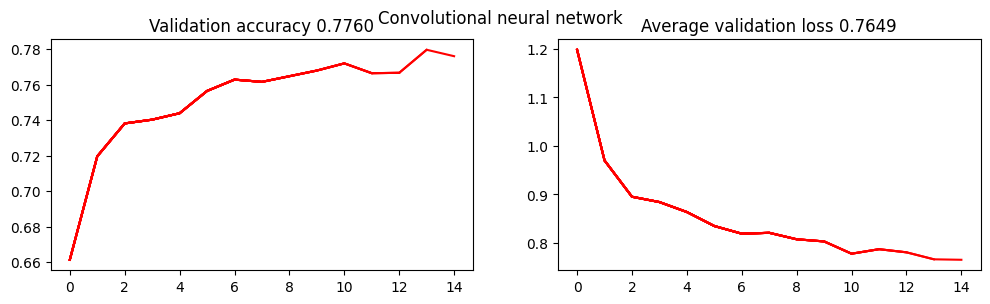

In [5]:
BATCH_SIZE = 64
EPOCHS = 15

training_data = DNNmodels.CustomImageDataset(X_train, y_train, model_type='cnn')
val_data = DNNmodels.CustomImageDataset(X_test, y_test, model_type='cnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

model_cnn = DNNmodels.CNN(num_classes=classes).to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = DNNmodels.EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Convolutional neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    DNNmodels.train(train_dataloader, model_cnn, loss_fn, optimizer)
    DNNmodels.test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    DNNmodels.plot_results(axs, result)

In [6]:
torch.save(model_cnn.state_dict(), './model_cnn_emnist.pt')

In [7]:
model_cnn = DNNmodels.CNN(num_classes=classes)
model_cnn.load_state_dict(torch.load('./model_cnn_emnist.pt'))
model_cnn.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
)

In [10]:
with open('./onlinehd_emnist.pickle', 'br') as f:
    model_onlinehd = pickle.load(f)

### FGSM

100%|██████████| 4700/4700 [00:11<00:00, 415.64it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 11.314579750000007 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 74.32%
mean of norm=0.009999998845160007


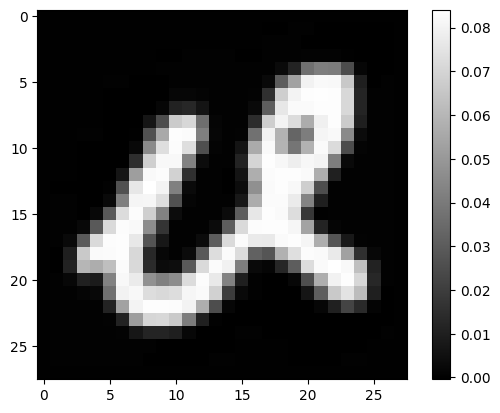

100%|██████████| 4700/4700 [00:11<00:00, 423.40it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 11.133882166000035 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 69.77%
mean of norm=0.019999995827674866


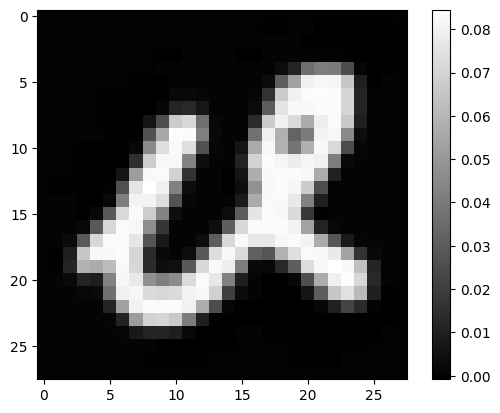

100%|██████████| 4700/4700 [00:11<00:00, 425.51it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 11.08386541699997 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 64.49%
mean of norm=0.029999999329447746


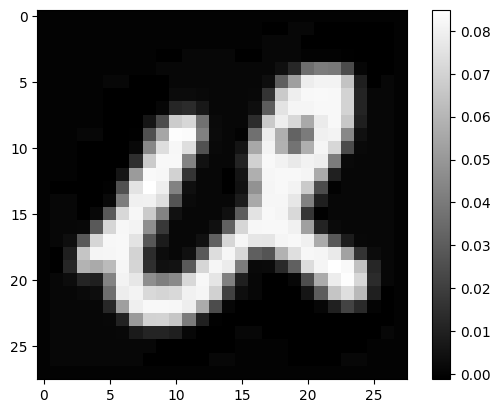

100%|██████████| 4700/4700 [00:10<00:00, 439.50it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 10.72790662500006 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 59.15%
mean of norm=0.03999999538064003


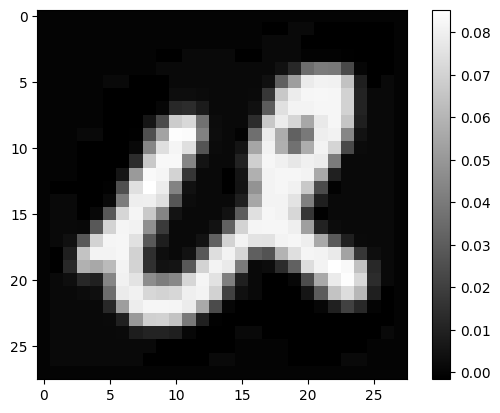

100%|██████████| 4700/4700 [00:10<00:00, 451.89it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 10.431924665999986 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 53.06%
mean of norm=0.05000000819563866


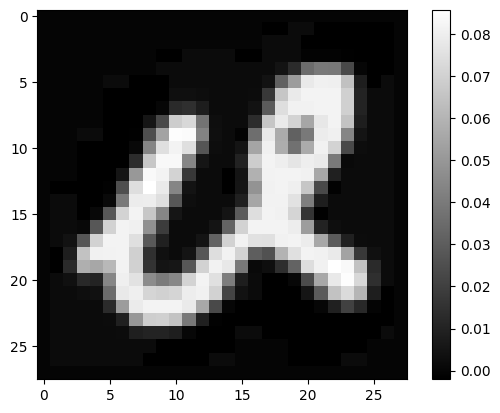

100%|██████████| 4700/4700 [00:10<00:00, 446.41it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 10.561974291999945 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 46.89%
mean of norm=0.05999999865889549


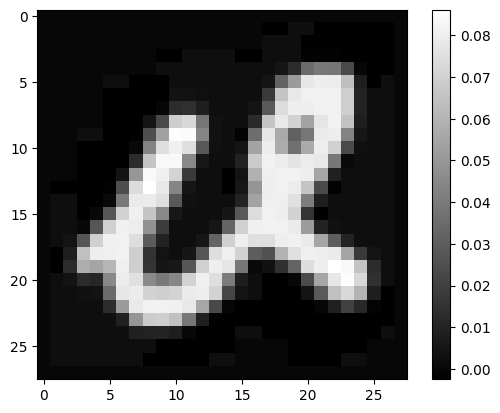

100%|██████████| 4700/4700 [00:10<00:00, 461.53it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 10.21569333299999 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 40.00%
mean of norm=0.06999999284744263


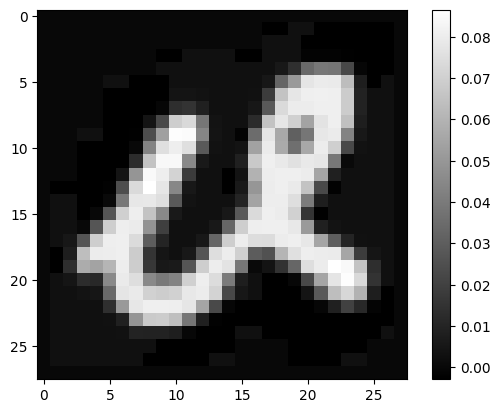

100%|██████████| 4700/4700 [00:10<00:00, 462.45it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 10.1954025 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 34.02%
mean of norm=0.07999999076128006


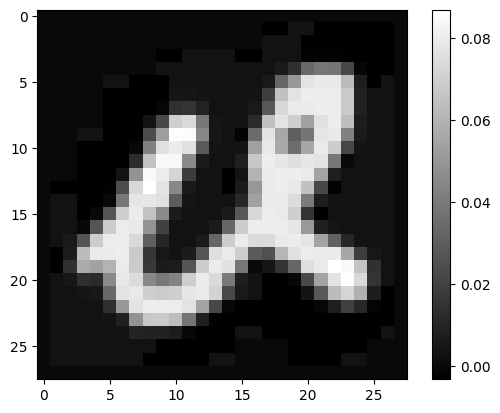

100%|██████████| 4700/4700 [00:10<00:00, 446.87it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 10.54888516699998 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 28.53%
mean of norm=0.09000002592802048


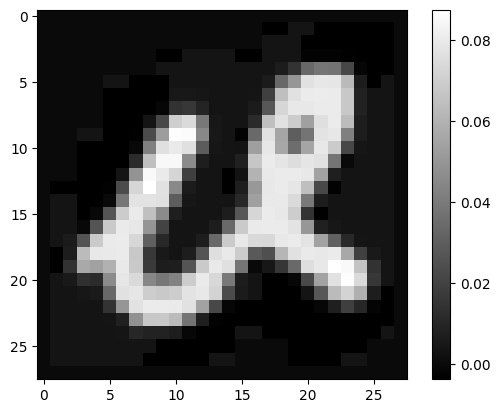

100%|██████████| 4700/4700 [00:10<00:00, 452.41it/s]



FGSM Attack with epsilon = 0.10000 | Elapsed time: 10.419535957999983 seconds.
Accuracy: Before the attack -> 77.60%	|	After the attack -> 23.70%
mean of norm=0.10000001639127731


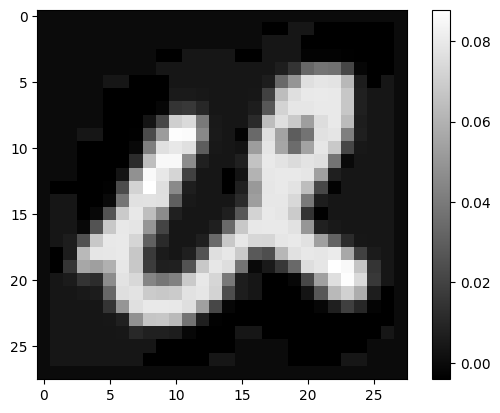

In [11]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
criterion = nn.CrossEntropyLoss()
#criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm_dnn.attack(
    model_cnn, X_train.reshape(len(X_train), 28, 28), X_test.reshape(len(X_test), 28, 28), y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu')

In [12]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, cnn_attacked_acc)

0.01 0.009999998845160007 0.757446825504303 0.7431914806365967
0.020000000000000004 0.019999995827674866 0.7478723526000977 0.6976595520973206
0.030000000000000006 0.029999999329447746 0.7391489148139954 0.6448936462402344
0.04000000000000001 0.03999999538064003 0.7319148778915405 0.5914893746376038
0.05000000000000001 0.05000000819563866 0.7248936295509338 0.5306382775306702
0.06000000000000001 0.05999999865889549 0.7159574627876282 0.46893617510795593
0.07 0.06999999284744263 0.7057446837425232 0.4000000059604645
0.08 0.07999999076128006 0.6974468231201172 0.34021276235580444
0.09000000000000001 0.09000002592802048 0.6880850791931152 0.28531914949417114
0.1 0.10000001639127731 0.6780850887298584 0.2370212823152542


### Deep Fool

In [13]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, 28, 28)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, 28, 28), model_cnn, epsilon=max_update)
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 4700/4700 [09:01<00:00,  8.68it/s]


541.7371490001678
0.01 0.008941646665334702 0.760212779045105 0.7674468159675598


100%|██████████| 4700/4700 [07:50<00:00,  9.98it/s]


470.9264671802521
0.02 0.017883293330669403 0.7565957307815552 0.7091489434242249


100%|██████████| 4700/4700 [07:04<00:00, 11.08it/s]


424.09794211387634
0.03 0.026824941858649254 0.7523404359817505 0.6399999856948853


100%|██████████| 4700/4700 [06:01<00:00, 12.99it/s]


361.83107709884644
0.04 0.035766586661338806 0.7489361763000488 0.5519148707389832


100%|██████████| 4700/4700 [04:44<00:00, 16.52it/s]


284.420578956604
0.05 0.044708240777254105 0.7457447052001953 0.45957446098327637


100%|██████████| 4700/4700 [04:06<00:00, 19.06it/s]


246.6189091205597
0.060000000000000005 0.05364988371729851 0.7408510446548462 0.3768085241317749


100%|██████████| 4700/4700 [03:11<00:00, 24.60it/s]


191.08005285263062
0.06999999999999999 0.06259153038263321 0.7351064085960388 0.3017021417617798


100%|██████████| 4700/4700 [02:38<00:00, 29.73it/s]


158.0925030708313
0.08 0.07153317332267761 0.7319148778915405 0.24574467539787292


100%|██████████| 4700/4700 [02:13<00:00, 35.30it/s]


133.14795589447021
0.09 0.0804748386144638 0.7253191471099854 0.2034042626619339


100%|██████████| 4700/4700 [02:01<00:00, 38.79it/s]


121.16321468353271
0.09999999999999999 0.08941648155450821 0.717659592628479 0.18276596069335938


100%|██████████| 4700/4700 [01:56<00:00, 40.33it/s]


116.52802205085754
0.11 0.09835812449455261 0.7078723311424255 0.17000000178813934


100%|██████████| 4700/4700 [01:51<00:00, 42.14it/s]


111.52303695678711
0.12 0.10729976743459702 0.6974468231201172 0.16255319118499756


100%|██████████| 4700/4700 [01:43<00:00, 45.49it/s]


103.32704305648804
0.13 0.11624140292406082 0.6878723502159119 0.15893617272377014


100%|██████████| 4700/4700 [01:42<00:00, 45.88it/s]


102.43596601486206
0.14 0.12518306076526642 0.6785106658935547 0.15744680166244507


100%|██████████| 4700/4700 [01:43<00:00, 45.53it/s]


103.23469161987305
0.15000000000000002 0.13412469625473022 0.6665957570075989 0.1568085104227066


100%|██████████| 4700/4700 [01:43<00:00, 45.56it/s]


103.16624593734741
0.16 0.14306634664535522 0.6580851078033447 0.1568085104227066


100%|██████████| 4700/4700 [01:42<00:00, 45.76it/s]


102.70870876312256
0.17 0.15200799703598022 0.6482978463172913 0.1559574455022812


100%|██████████| 4700/4700 [01:42<00:00, 45.71it/s]


102.81662201881409
0.18000000000000002 0.1609496772289276 0.6365957260131836 0.15553191304206848


100%|██████████| 4700/4700 [01:42<00:00, 45.95it/s]


102.2852668762207
0.19 0.16989131271839142 0.6242552995681763 0.15489362180233002


100%|██████████| 4700/4700 [01:43<00:00, 45.36it/s]


103.6136360168457
0.2 0.17883296310901642 0.6125531792640686 0.1540425568819046


In [14]:
X_te_cln = X_test.clone().reshape(-1, 1, 28, 28)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

st = time.time()
for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df_dnn.deepfool(X_te_cln[i].reshape(1, 28, 28), model_cnn, epsilon=None)
print(time.time() - st)

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test_onlinehd = model_onlinehd(X_test_noised.reshape(-1, 28*28))
yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test_onlinehd).float().mean().item()
cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 4700/4700 [01:41<00:00, 46.28it/s]


101.5546989440918
None 0.11468659341335297 0.6810638308525085 0.1587233990430832


### Genetic Attack

In [13]:
alpha_lis = np.linspace(0.0004, 0.0037, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen_dnn.make_GA(model_cnn, delta, alpha, x_test_samp.reshape(-1, 28*28), y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model_onlinehd(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0004


 14%|█▍        | 144/1000 [05:54<39:15,  2.75s/it]